In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, explained_variance_score
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr
from side_info_decoding.utils import set_seed, load_data_from_pids
from side_info_decoding.reduced_rank import Reduced_Rank_CNN, train_single_task, model_eval

seed = 666
set_seed(seed)

In [2]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
]

In [123]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="po",
    behavior="wheel_velocity",
    data_type="all_ks",
    n_t_bins = 40,
    t_before = .5,
    t_after = 1.5,
    normalize_input=False
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 269 (active: 269)
prior for this session is not found.
found 269 trials from 17.56 to 2310.24 sec.
found 163 Kilosort units in region po


Compute spike count: 100%|███████████████████| 269/269 [00:00<00:00, 740.50it/s]


In [124]:
pid = pids[0]
X, Y = X_dict[pid], Y_dict[pid]
print(X.shape)
print(Y.shape)

(269, 159, 40)
(269, 40)


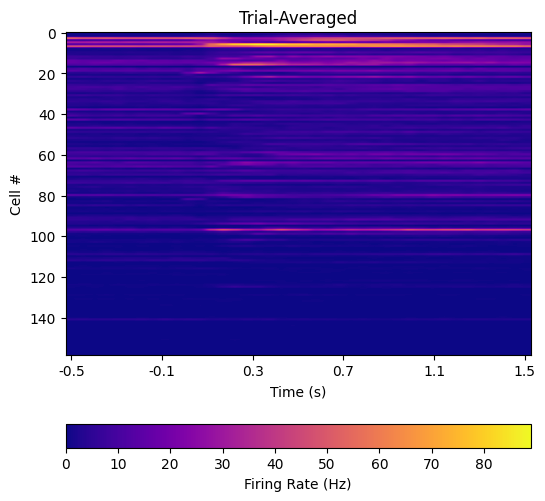

In [125]:
plt.figure(figsize = (6,6))
plt.imshow(X.mean(0)/0.05, aspect="auto", cmap=plt.cm.plasma)
plt.xticks(np.linspace(0, 39, 6), ['%.1f'%i for i in np.linspace(-0.5, 1.5, 6)])
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)')
plt.title('Trial-Averaged');

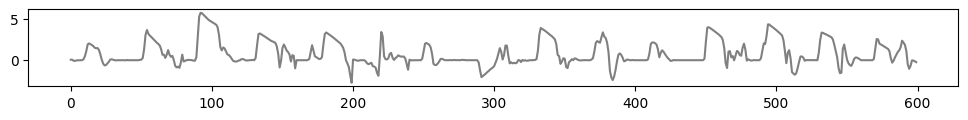

In [126]:
plt.figure(figsize=(12,1))
plt.plot(Y[10:10+15].flatten(), c="gray");

#### smoothing 

In [127]:
K, C, T = X.shape
smooth_X = np.array(
    [[gaussian_filter1d(X[k, c, :], 4) for c in range(C)] for k in range(K)]
) # (K, C, T)
norm_Y = normalize(Y)

In [128]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
penalty = [0.001, 0.01, 1, 100, 1000, 10000]

obs_lst, pred_lst, r2_lst, corr_lst = [], [], [], []
for fold_idx, (train, test) in enumerate(kf.split(smooth_X)):
    train_X, test_X = smooth_X[train], smooth_X[test]
    train_Y, test_Y = norm_Y[train], norm_Y[test]
    train_X = np.moveaxis(train_X, 1, -1).reshape((-1, C))
    test_X = np.moveaxis(test_X, 1, -1).reshape((-1, C))
    train_Y = train_Y.reshape((-1))
    test_Y = test_Y.reshape((-1))
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    # decoder = Ridge(alpha=1000)
    decoder.fit(train_X, train_Y)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(len(test), T)
    pred_Y = pred_Y.reshape(len(test), T)
    obs_lst.append(test_Y)
    pred_lst.append(pred_Y)
    r2_lst.append(r2_score(test_Y.flatten(), pred_Y.flatten()))
    corr_lst.append(pearsonr(test_Y.flatten(), pred_Y.flatten())[0])

obs_lst = np.vstack(obs_lst)     
pred_lst = np.vstack(pred_lst)    
print(f"5-fold CV r2: {np.mean(r2_lst)} corr: {np.mean(corr_lst)}")

5-fold CV r2: 0.13208256459487525 corr: 0.3695579678795773


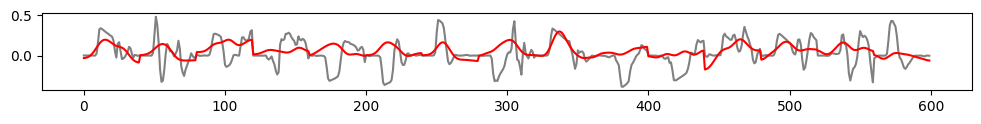

In [130]:
plt.figure(figsize=(12,1))
plt.plot(obs_lst[10:10+15].flatten(), c="gray")
plt.plot(pred_lst[10:10+15].flatten(), c="r");

#### conv reduced-rank

In [3]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="po",
    behavior="wheel_velocity",
    data_type="all_ks",
    n_t_bins = 40,
    t_before = .5,
    t_after = 1.5,
    normalize_input=True
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 269 (active: 269)
prior for this session is not found.
found 269 trials from 17.56 to 2310.24 sec.
found 163 Kilosort units in region po


Compute spike count: 100%|███████████████████| 269/269 [00:00<00:00, 713.91it/s]


In [12]:
n_epochs = 500
n_folds = 5
filter_length = 3
R = 2

pid = pids[0]
X, Y = X_dict[pid], Y_dict[pid]
K, C, T = X.shape
X_tensor = torch.tensor(X)
Y_tensor = torch.tensor(normalize(Y))

kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

obs_lst, pred_lst, metrics_lst, U_lst, V_lst = [], [], [], [], []
for fold_idx, (train, test) in enumerate(kf.split(X)):

    train_X, test_X = X_tensor[train], X_tensor[test]
    train_Y, test_Y = Y_tensor[train], Y_tensor[test]

    rrm = Reduced_Rank_CNN(
        n_units=C, 
        n_t_bins=T, 
        rank=R,
        filter_length=filter_length
    )

    rrm, losses = train_single_task(
        model=rrm,
        train_dataset=(train_X, train_Y),
        test_dataset=(test_X, test_Y),
        loss_function=torch.nn.MSELoss(),
        learning_rate=1e-2,
        weight_decay=1e-2,
        n_epochs=n_epochs,
    )

    with torch.no_grad():
        test_U, test_V, test_metrics, test_pred = model_eval(
            rrm, 
            (train_X, train_Y),
            (test_X, test_Y),
            behavior="continuous"
        )
        test_pred = test_pred.detach().numpy()

    obs_lst.append(test_Y)
    pred_lst.append(test_pred)
    U_lst.append(test_U)
    V_lst.append(test_V)
    metrics_lst.append(test_metrics)

print(f"5-fold CV r2: {np.mean(metrics_lst, 0)[0]} corr: {np.mean(metrics_lst, 0)[1]}")

Epoch [50/500], Loss: 0.019038897911382927
Epoch [100/500], Loss: 0.018932453831290656
Epoch [150/500], Loss: 0.018933090491263238
Epoch [200/500], Loss: 0.018933045039236526
Epoch [250/500], Loss: 0.01893301429994253
Epoch [300/500], Loss: 0.018933015559606275
Epoch [350/500], Loss: 0.01893301549410963
Epoch [400/500], Loss: 0.018933015489516106
Epoch [450/500], Loss: 0.01893301548994838
Epoch [500/500], Loss: 0.018933008161922834
train r2: 0.132 corr: 0.374
test r2: 0.108 corr: 0.333
Epoch [50/500], Loss: 0.0199612215725093
Epoch [100/500], Loss: 0.01901999806393311
Epoch [150/500], Loss: 0.018991065507600158
Epoch [200/500], Loss: 0.01899071865765628
Epoch [250/500], Loss: 0.018990771658016492
Epoch [300/500], Loss: 0.018990775750682896
Epoch [350/500], Loss: 0.01899077600068811
Epoch [400/500], Loss: 0.01899077596410091
Epoch [450/500], Loss: 0.018990775964689222
Epoch [500/500], Loss: 0.018990775964818057
train r2: 0.126 corr: 0.365
test r2: 0.129 corr: 0.366
Epoch [50/500], Loss:

In [13]:
obs_lst = np.vstack(obs_lst)     
pred_lst = np.vstack(pred_lst) 
U_lst = np.stack(U_lst) 
V_lst = np.hstack(V_lst)

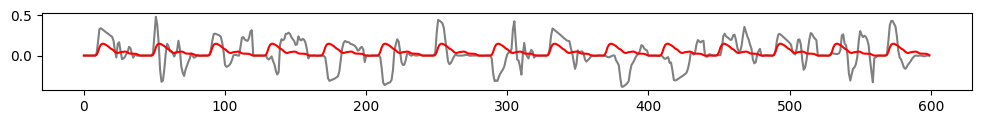

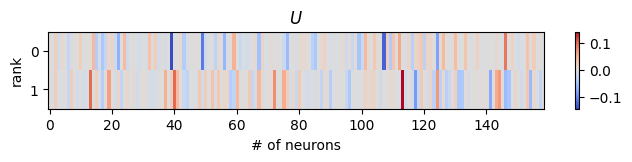

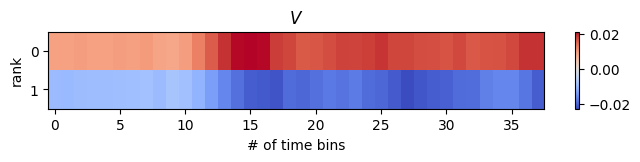

In [14]:
plt.figure(figsize=(12,1))
plt.plot(obs_lst[10:10+15].flatten(), c="gray")
plt.plot(pred_lst[10:10+15].flatten(), c="r")

plt.figure(figsize=(8,1))
plt.imshow(np.mean(U_lst, 0).T, aspect="auto", cmap="coolwarm")
plt.colorbar()
plt.xlabel("# of neurons")
plt.ylabel("rank")
plt.title(r"$U$");

plt.figure(figsize=(8,1))
plt.imshow(np.mean(V_lst, (1,2)), aspect="auto", cmap="coolwarm")
plt.colorbar()
plt.xlabel("# of time bins")
plt.ylabel("rank")
plt.title(r"$V$");